### Mountain

Build time : 0.92


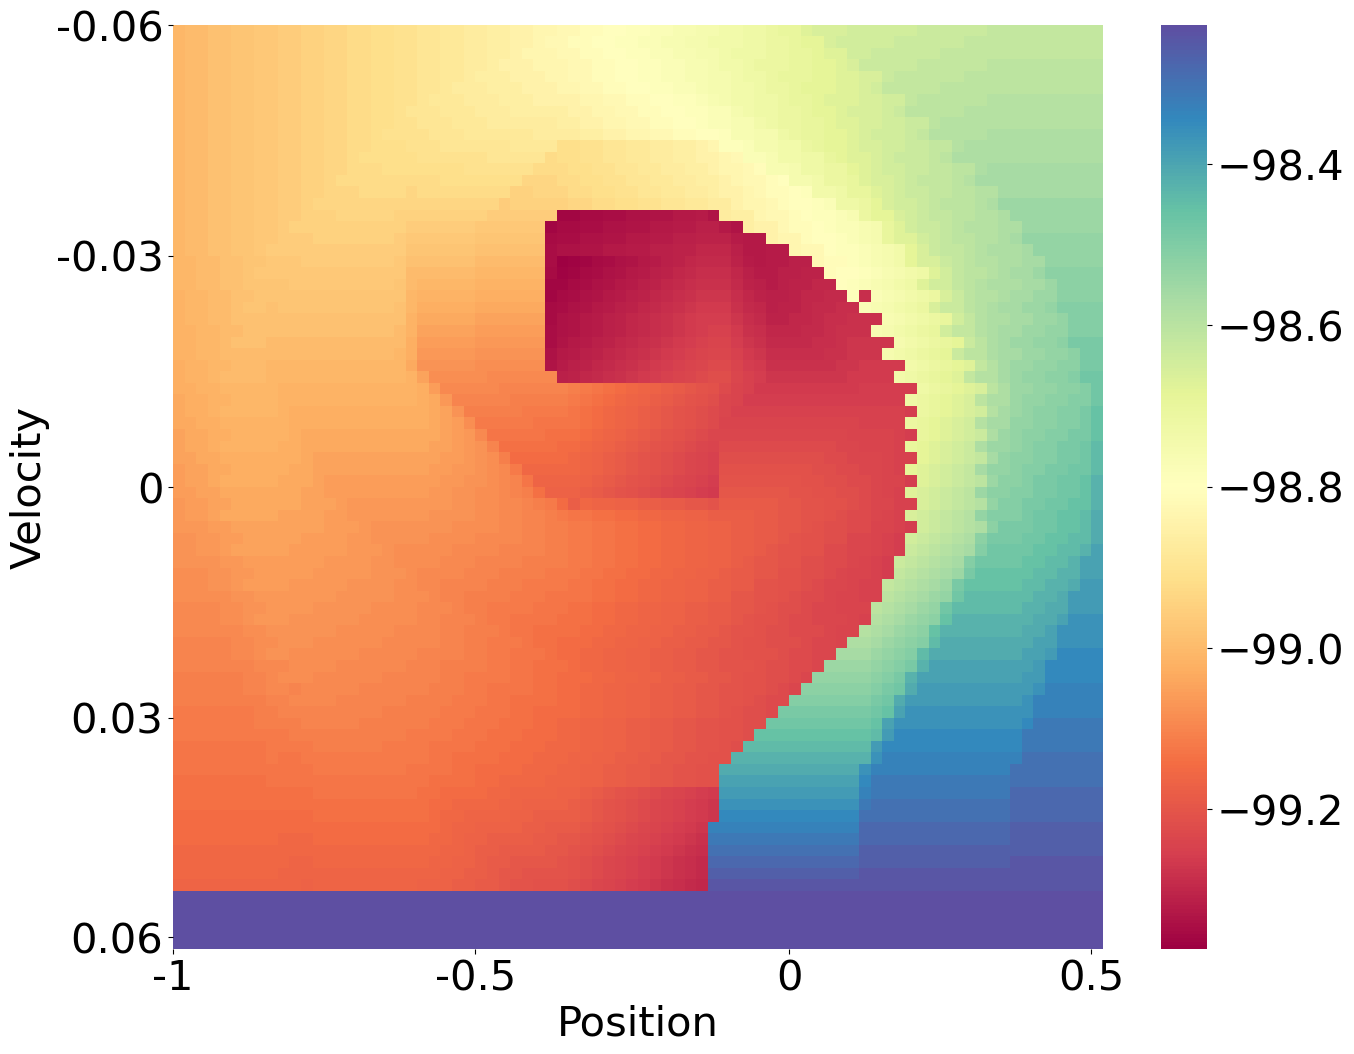

In [2]:
from utils.exact_value_function import get_exact_value
from solvers.aggregated_qvi import Solver as Aqvi
from models.mountain import Model as mnt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os

try:
    os.mkdir('figures') 
except FileExistsError:
    pass  # Directory already exists, no action needed

side = 80
size = side**2

model = mnt(size, 3)
model.create_model()

# value = get_exact_value(model, 0.99)
# plt.figure(figsize=(12, 10))
# sns.heatmap(value.reshape((side, side)), cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
# plt.savefig('figures/optimal_value_mountain.jpg')
# plt.show()

from solvers.aggregated_qvi import Solver as Aqvi

solver = Aqvi(model, 0.99, 1e-2)
solver.run()

optimal_aggregated_value = solver.value.reshape((side, side))


cmap = sns.color_palette("Spectral", as_cmap=True)

plt.figure(figsize=(15, 12))
sns.heatmap(optimal_aggregated_value, cmap=cmap, xticklabels=False, yticklabels=False)
plt.xlabel("Position", size=30)
plt.ylabel("Velocity", size=30)
plt.savefig("figures/partition_mountain.jpg")
xticks = [
    0,
    optimal_aggregated_value.shape[1] // 3,
    2 * optimal_aggregated_value.shape[1] // 3,
    optimal_aggregated_value.shape[1] - 1,
]
plt.xticks(
    ticks=xticks,
    labels=["-1", "-0.5", "0", "0.5"],
)
yticks = [
    0,
    optimal_aggregated_value.shape[0] // 4,
    optimal_aggregated_value.shape[0] // 2,
    3 * optimal_aggregated_value.shape[0] // 4,
    optimal_aggregated_value.shape[0] - 1,
]
plt.yticks(
    ticks=yticks,
    labels=["-0.06", "-0.03", "0", "0.03", "0.06"],
)
plt.tick_params(
    axis="both", which="major", labelsize=30
)  # Adjust tick size for both axes
# plt.legend()

cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.savefig("figures/optimal_value_mountain.pdf", bbox_inches="tight")
plt.show()

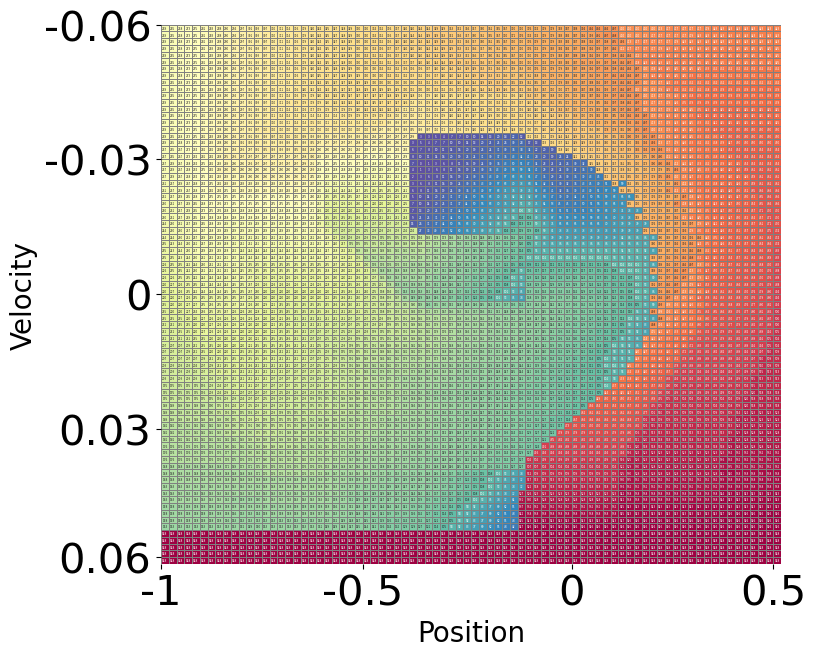

In [14]:
regions = np.zeros((side, side), dtype=int)

for region_id, value in enumerate(sorted(list(set(optimal_aggregated_value.flatten())))):
    states = np.argwhere(optimal_aggregated_value == value)
    for state in states:
        regions[state[0], state[1]] = region_id

cmap = sns.color_palette("Spectral", as_cmap=True).reversed()

plt.close()
plt.figure(figsize=(8, 7))
sns.heatmap(
    regions,
    annot=True,
    fmt="d",
    # cmap="icefire",
    cmap=cmap,
    linewidths=0.5,
    linecolor="gray",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    annot_kws={"size": 2},
)
# plt.title("State Abstraction (Abstract State ID)")
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
plt.xlabel("Position", size=20)
plt.ylabel("Velocity", size=20)
# plt.gca().invert_yaxis()  # Optional: so that (0,0) is at the bottom-left like in RL environments
xticks = [
    0,
    optimal_aggregated_value.shape[1] // 3,
    2 * optimal_aggregated_value.shape[1] // 3,
    optimal_aggregated_value.shape[1] - 1,
]
plt.xticks(
    ticks=xticks,
    labels=["-1", "-0.5", "0", "0.5"],
)
yticks = [
    0,
    optimal_aggregated_value.shape[0] // 4,
    optimal_aggregated_value.shape[0] // 2,
    3 * optimal_aggregated_value.shape[0] // 4,
    optimal_aggregated_value.shape[0] - 1,
]
plt.yticks(
    ticks=yticks,
    labels=["-0.06", "-0.03", "0", "0.03", "0.06"],
)
plt.tick_params(
    axis="both", which="major", labelsize=30
)  # Adjust tick size for both axes
# plt.legend()
# plt.tight_layout()
plt.savefig("figures/abstraction_mountain.pdf", bbox_inches='tight')
plt.show()

### Four Rooms

In [2]:
from io import BytesIO

# from socket import CAN_RAW_ERR_FILTER
import sys
from turtle import right
from typing import Optional

from matplotlib import scale
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import portrait, landscape
from pypdf import PdfReader, PdfWriter

# Conversion: 1 mm = 72 points per inch / 25.4 mm per inch
POINTS_PER_MM = 72.0 / 25.4  # ≈ 2.834645669291339


def create_line_overlay_pdf_coords(
    page_width_pt: float,
    page_height_pt: float,
    x_start_mm: float,
    y_start_mm: float,
    x_end_mm: float,
    y_end_mm: float,
    stroke_width_mm: float = 1.0,
) -> BytesIO:
    """
    Create an in-memory single-page PDF overlay that contains a single line
    defined by start and end coordinates (in mm from bottom-left of the page).
    """
    mem = BytesIO()
    c = canvas.Canvas(mem, pagesize=(page_width_pt, page_height_pt))

    # Stroke width in points
    stroke_width_pt = stroke_width_mm * POINTS_PER_MM
    c.setLineWidth(stroke_width_pt)
    c.setStrokeColorRGB(0, 0, 0)  # black

    # Convert mm to points
    x0 = x_start_mm * POINTS_PER_MM
    y0 = y_start_mm * POINTS_PER_MM
    x1 = x_end_mm * POINTS_PER_MM
    y1 = y_end_mm * POINTS_PER_MM

    # Draw the line
    c.line(x0, y0, x1, y1)

    c.showPage()
    c.save()
    mem.seek(0)
    return mem


def draw_line_on_pdf(
    input_pdf_path: str,
    output_pdf_path: str,
    page_number: int = 0,
    x_start_mm: float = 10.0,
    y_start_mm: float = 20.0,
    x_end_mm: float = 100.0,
    y_end_mm: float = 20.0,
    stroke_width_mm: float = 1.0,
) -> None:
    """
    Draws a line from (x_start_mm, y_start_mm) to (x_end_mm, y_end_mm) in mm
    on the specified page of the PDF, preserving vector content.
    Coordinates are measured from bottom-left of the page.
    """
    reader = PdfReader(input_pdf_path)
    if page_number < 0 or page_number >= len(reader.pages):
        raise IndexError(
            f"page_number {page_number} out of range (0..{len(reader.pages)-1})"
        )

    page = reader.pages[page_number]

    # Page size in points
    media_box = page.mediabox
    page_width_pt = float(media_box.width)
    page_height_pt = float(media_box.height)

    # Prepare overlay PDF
    overlay_pdf_bytes = create_line_overlay_pdf_coords(
        page_width_pt=page_width_pt,
        page_height_pt=page_height_pt,
        x_start_mm=x_start_mm,
        y_start_mm=y_start_mm,
        x_end_mm=x_end_mm,
        y_end_mm=y_end_mm,
        stroke_width_mm=stroke_width_mm,
    )

    # Merge overlay onto original page
    overlay_reader = PdfReader(overlay_pdf_bytes)
    overlay_page = overlay_reader.pages[0]
    page.merge_page(overlay_page)

    # Write updated PDF
    writer = PdfWriter()
    for p in reader.pages:
        writer.add_page(p)

    with open(output_pdf_path, "wb") as f_out:
        writer.write(f_out)


def add_rooms_layout(
    input_pdf: str,
    output_pdf: str,
    x_debut,
    y_debut,
    x_fin,
    y_fin,
):
    carreau_x = (x_fin - x_debut) / 10
    carreau_y = (y_fin - y_debut) / 10

    x_mid = x_debut + 5 * carreau_x
    y_mid = y_debut + 5 * carreau_y

    width_mm = 1.5

    # Bas gauche to haut gauche
    draw_line_on_pdf(
        input_pdf_path=input_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_debut,
        y_start_mm=y_debut,
        x_end_mm=x_debut,
        y_end_mm=y_fin,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_debut,
        y_start_mm=y_fin,
        x_end_mm=x_fin,
        y_end_mm=y_fin,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_fin,
        y_start_mm=y_fin,
        x_end_mm=x_fin,
        y_end_mm=y_debut,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_fin,
        y_start_mm=y_debut,
        x_end_mm=x_debut,
        y_end_mm=y_debut,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_mid,
        y_start_mm=y_debut,
        x_end_mm=x_mid,
        y_end_mm=y_debut + 2 * carreau_y,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_mid,
        y_start_mm=y_debut + 3 * carreau_y,
        x_end_mm=x_mid,
        y_end_mm=y_debut + 7 * carreau_y,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_mid,
        y_start_mm=y_debut + 8 * carreau_y,
        x_end_mm=x_mid,
        y_end_mm=y_debut + 10 * carreau_y,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_debut,
        y_start_mm=y_mid,
        x_end_mm=x_debut + 2 * carreau_x,
        y_end_mm=y_mid,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_debut + 3 * carreau_x,
        y_start_mm=y_mid,
        x_end_mm=x_debut + 7 * carreau_x,
        y_end_mm=y_mid,
        stroke_width_mm=width_mm,
    )

    draw_line_on_pdf(
        input_pdf_path=output_pdf,
        output_pdf_path=output_pdf,
        page_number=0,
        x_start_mm=x_debut + 8 * carreau_x,
        y_start_mm=y_mid,
        x_end_mm=x_debut + 10 * carreau_x,
        y_end_mm=y_mid,
        stroke_width_mm=width_mm,
    )

In [3]:
from matplotlib import scale
import seaborn as sns
import matplotlib.pyplot as plt

from models.rooms import Model as Rooms

model = Rooms(100, 4)
model.create_model()

from solvers.aggregated_qvi import Solver as Aqvi

solver = Aqvi(model, 0.99, 1e-1)
solver.run()

value = solver.value.reshape((10, 10))
# value -= min(solver.value.flatten())

cmap = sns.color_palette("Spectral", as_cmap=True)

plt.figure(figsize=(15, 12))
sns.heatmap(value, cmap=cmap, xticklabels=False, yticklabels=False)
plt.savefig("figures/value_rooms.pdf")
plt.tick_params(
    axis="both", which="major", labelsize=30
)  # Adjust tick size for both axes
# plt.legend()

cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

plt.savefig("figures/value_rooms.pdf", bbox_inches="tight")
plt.close()

add_rooms_layout("figures/value_rooms.pdf", "figures/value_rooms_lines.pdf", x_debut=2.5, y_debut=2.5, x_fin=239, y_fin = 237.5)

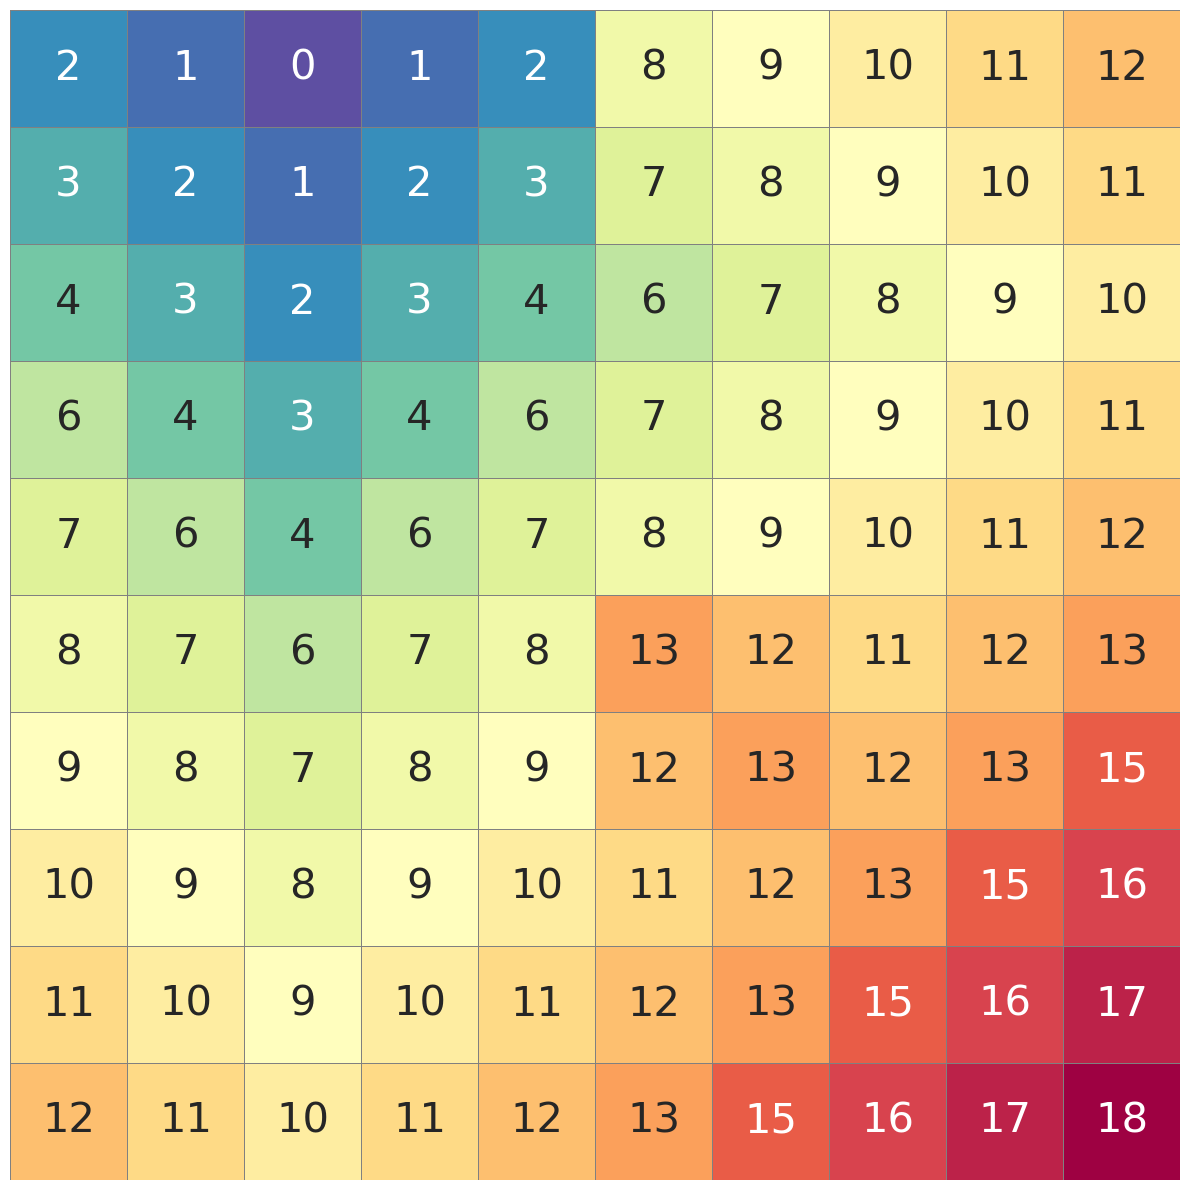

In [4]:
cmap = sns.color_palette("Spectral", as_cmap=True).reversed()

plt.figure(figsize=(12, 12))
sns.heatmap(
    -value.astype(int),
    annot=True,
    fmt="d",
    # cmap="tab20",
    cmap=cmap,
    linewidths=0.5,
    linecolor="gray",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    annot_kws={"size": 30},
)
# plt.title("State Abstraction (Abstract State ID)")
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# plt.gca().invert_yaxis()  # Optional: so that (0,0) is at the bottom-left like in RL environments
plt.tight_layout()
plt.savefig("figures/four_rooms_abstraction.pdf", bbox_inches='tight')
plt.show()
plt.close()

add_rooms_layout("figures/four_rooms_abstraction.pdf", "figures/four_rooms_abstraction_lines.pdf", x_debut=2.5, y_debut=2.5, x_fin=300, y_fin = 300)

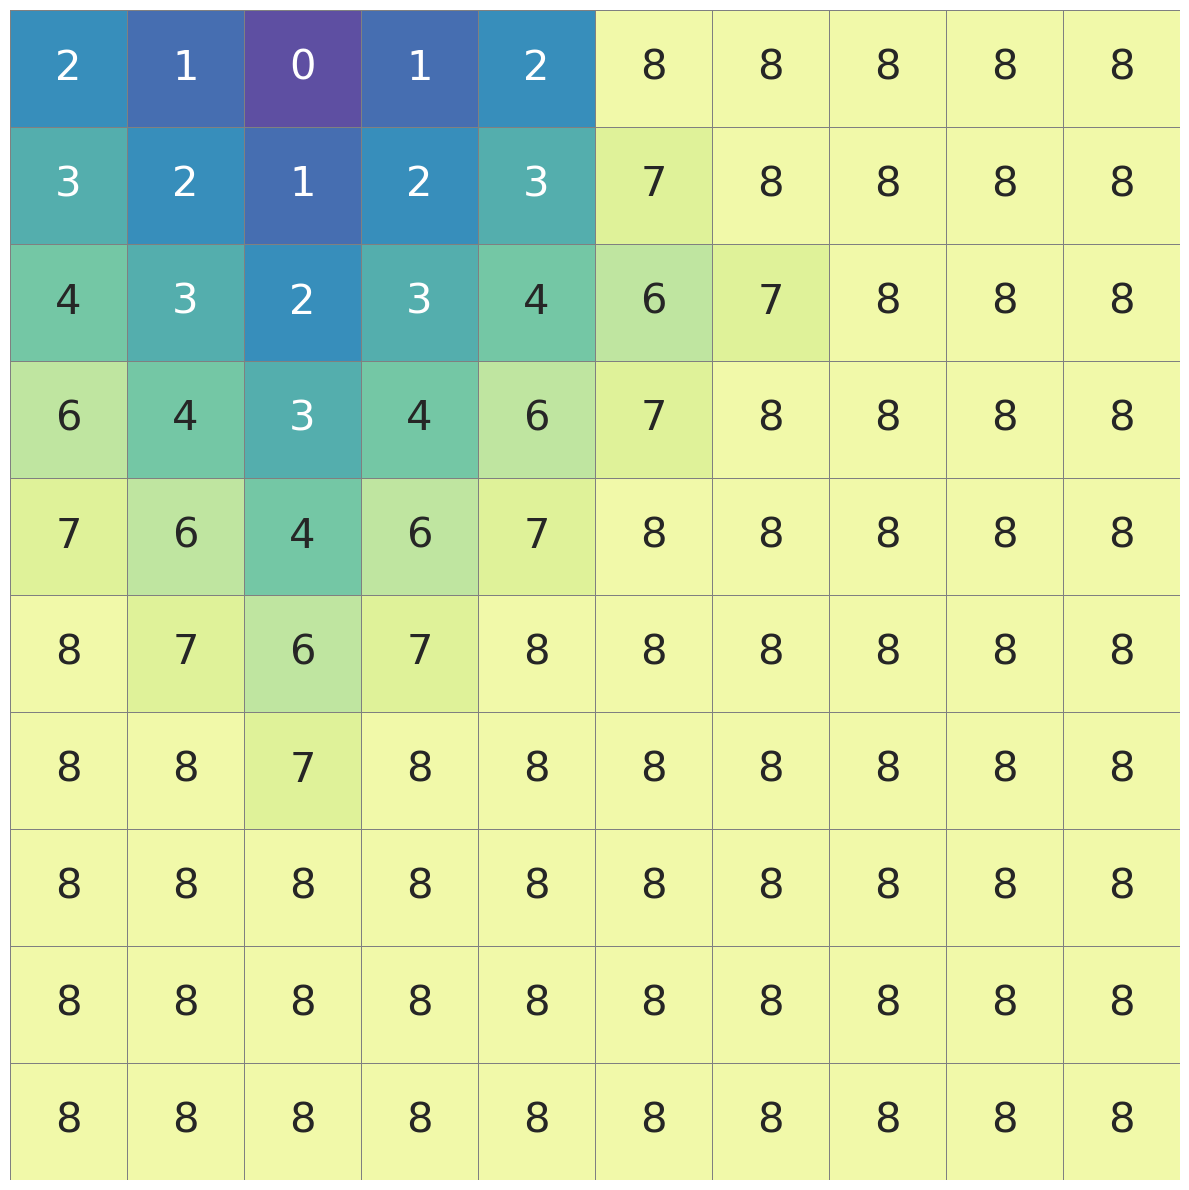

In [5]:
val2 = -value.astype(int).copy()
val2[val2 >= 8] = 8

cmap = sns.color_palette("Spectral", as_cmap=True).reversed()

plt.figure(figsize=(12, 12))
sns.heatmap(
    val2,
    annot=True,
    fmt="d",
    # cmap="tab20",
    cmap=cmap,
    linewidths=0.5,
    linecolor="gray",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    annot_kws={"size": 30},
    vmax=18,
    vmin=0
)
# plt.title("State Abstraction (Abstract State ID)")
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# plt.gca().invert_yaxis()  # Optional: so that (0,0) is at the bottom-left like in RL environments

file_name = "figures/four_rooms_abstraction_discovery_2.pdf"
lines_file_name = "figures/four_rooms_abstraction_discovery_2_lines.pdf"

plt.tight_layout()
plt.savefig(file_name, bbox_inches='tight')
plt.show()

add_rooms_layout(file_name, lines_file_name, x_debut=2.5, y_debut=2.5, x_fin=300, y_fin = 300)

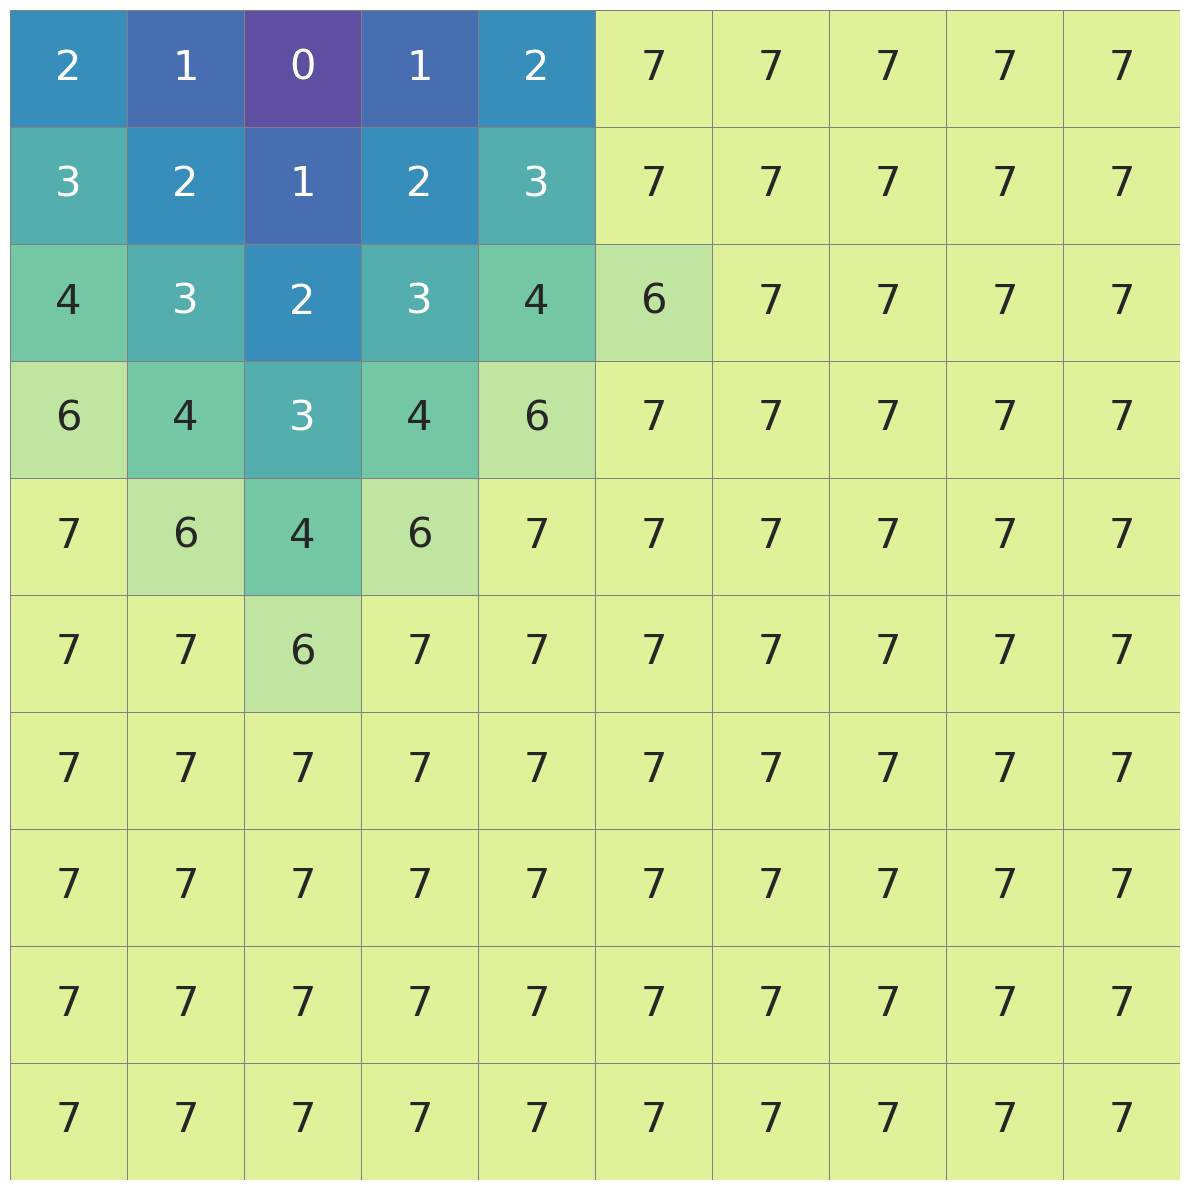

In [6]:
val1 = -value.astype(int).copy()
val1[val1 >= 7] = 7

cmap = sns.color_palette("Spectral", as_cmap=True).reversed()

plt.figure(figsize=(12, 12))
sns.heatmap(
    val1,
    annot=True,
    fmt="d",
    # cmap="tab20",
    cmap=cmap,
    linewidths=0.5,
    linecolor="gray",
    cbar=False,
    xticklabels=False,
    yticklabels=False,
    annot_kws={"size": 30},
    vmin=0,
    vmax=18,
)
# plt.title("State Abstraction (Abstract State ID)")
# plt.xlabel("X Position")
# plt.ylabel("Y Position")
# plt.gca().invert_yaxis()  # Optional: so that (0,0) is at the bottom-left like in RL environments

file_name = "figures/four_rooms_abstraction_discovery_1.pdf"
lines_file_name = "figures/four_rooms_abstraction_discovery_1_lines.pdf"

plt.tight_layout()
plt.savefig(file_name, bbox_inches='tight')
plt.show()

add_rooms_layout(file_name, lines_file_name, x_debut=2.5, y_debut=2.5, x_fin=300, y_fin = 300)